## loading Data

In [2]:
from PIL import Image
path2content= "./content.jpg"
path2style= "./style.jpg"
content_img = Image.open(path2content)
style_img = Image.open(path2style)

In [23]:
# content_img

In [24]:
# style_img

In [5]:
import torchvision.transforms as transforms

h, w = 256, 384 
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
                    transforms.Resize((h,w)),  
                    transforms.ToTensor(),
                    transforms.Normalize(mean_rgb, std_rgb)])  

In [6]:
content_tensor = transformer(content_img)
print(content_tensor.shape, content_tensor.requires_grad)

torch.Size([3, 256, 384]) False


In [7]:
style_tensor = transformer(style_img)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 256, 384]) False


In [8]:
input_tensor = content_tensor.clone().requires_grad_(True)
print(input_tensor.shape, input_tensor.requires_grad)

torch.Size([3, 256, 384]) True


In [9]:
import torch

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c*=torch.tensor(std_rgb).view(3, 1,1)
    img_tensor_c+=torch.tensor(mean_rgb).view(3, 1,1)
    img_tensor_c = img_tensor_c.clamp(0,1)
    img_pil=to_pil_image(img_tensor_c)
    return img_pil

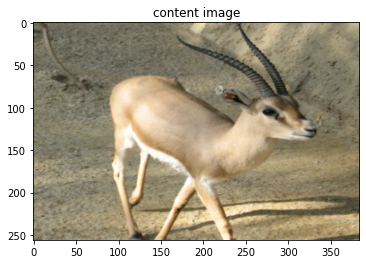

In [10]:
import matplotlib.pylab as plt
%matplotlib inline
from torchvision.transforms.functional import to_pil_image

plt.imshow(imgtensor2pil(content_tensor))
plt.title("content image");

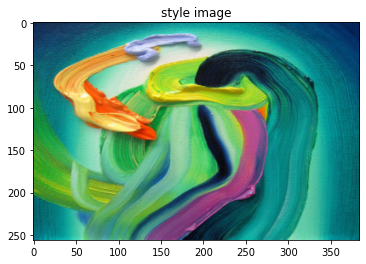

In [11]:
plt.imshow(imgtensor2pil(style_tensor))
plt.title("style image");

In [13]:
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_vgg = models.vgg19(pretrained=True).features.to(device).eval()
for param in model_vgg.parameters():
    param.requires_grad_(False)   
print(model_vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [14]:
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

In [15]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n*c, h * w)
    gram = torch.mm(x, x.t())
    return gram

In [16]:
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
    target= target_features[layer]
    pred = pred_features [layer]
    loss = F.mse_loss(pred, target)
    return loss

In [17]:
def get_style_loss(pred_features, target_features, style_layers_dict):  
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix (target_features[layer])
        layer_loss = style_layers_dict[layer] *  F.mse_loss(pred_gram, target_gram)
        loss += layer_loss/ (n* c * h * w)
    return loss

In [18]:
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)

In [19]:
for key in content_features.keys():
    print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


In [20]:
from torch import optim

input_tensor = con_tensor.clone().requires_grad_(True)
optimizer = optim.Adam([input_tensor], lr=0.01)

In [21]:
num_epochs = 300
content_weight = 1e1
style_weight = 1e4
content_layer = "conv5_1"
style_layers_dict = { 'conv1_1': 0.75,
                      'conv2_1': 0.5,
                      'conv3_1': 0.25,
                      'conv4_1': 0.25,
                      'conv5_1': 0.25}

for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg, feature_layers)
    content_loss = get_content_loss (input_features, content_features, content_layer)
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss {:.2}'.format(
          epoch,content_loss, style_loss))


epoch 0, content loss: 0.0, style loss 3.3e+02
epoch 100, content loss: 3.6, style loss 9e+01
epoch 200, content loss: 3.9, style loss 5.6
epoch 300, content loss: 4.0, style loss 3.3


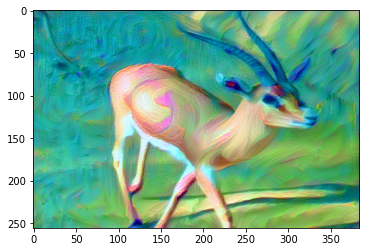

In [22]:
plt.imshow(imgtensor2pil(input_tensor[0].cpu()));